In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [23]:
#Границы отрезка и начальное условие в точке a
a = 1
b = 3
y0 = 1

In [24]:
def ODE(x, y):
    #Диф. уравнение
    return - (1 + x * y) / x ** 2

In [25]:
def exact_solution(x):
    #Точное решение диф. уравнения
    return (1 - np.log(np.abs(x))) / x

In [26]:
def runge_kutta_one_step(f, x, y, h, k1=None):
    ''' Шаг метода Рунге-Кутта 4-го порядка
        Функция принимает:
        f - диф. уравнение
        x - точку, в которой считаем новое приближение
        y - прошлое приближение
        h - длина шага 
        k1 - первый коэффициент метода
        Функция возвращает новое приближение'''
    
    k1 = f(x, y)
    k2 = f(x + h / 2, y + h / 2 * k1)
    k3 = f(x + h / 2, y + h / 2 * k2)
    k4 = f(x + h, y + h * k3)
    return y + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [27]:
def runge_kutta(f, x, y0, h0, eps):
    ''' Метод Рунге-Кутта 4-го порядка, используется для получения разгонных точек для метода Адамса-Башфорда 
        Функция принимает:
        f - диф. уравнение
        x - точка, в которой ищем приближение
        y0 - начальное условие в точке a
        h0 - стартовый шаг
        eps - заданная точность 
        Функция возвращает новое прибижение с заданной точностью'''
        
    y = y0
    h = h0
    k1h = f(x, y)
    y_h1 = runge_kutta_one_step(f, x, y, h, k1=k1h)
    y_h2 = runge_kutta_one_step(f, x + h, y_h1, h)
   
    y_2h = runge_kutta_one_step(f, x, y, 2 * h, k1=k1h)

    # Вычисляем ошибку
    error = np.linalg.norm((y_2h - y_h2) / 15)
    
    # Применяем поправку Ричардсона
    y_new = y_h2 + (y_h2 - y_2h) / 15
    
    while error > eps:  
        # Делаем два шага метода по h
        if y_h1 is None:
            k1h = f(x, y)
            y_h1 = runge_kutta_one_step(f, x, y, h, k1=k1h)
            y_h2 = runge_kutta_one_step(f, x + h, y_h1, h)
        # Делаем один шаг 2h
        if y_2h is None:
            y_2h = runge_kutta_one_step(f, x, y, 2 * h, k1=k1h)

        # Вычисляем ошибку
        error = np.linalg.norm((y_2h - y_h2) / 15)
        
        # Применяем поправку Ричардсона
        y_new = y_h2 + (y_h2 - y_2h) / 15

      
         # Провеяем достижение заданной точности
        if error <= eps:  
            y_h1 = None
            y_2h = None
            x += 2 * h
            y = y_new
        
            # Если ошибка намного меньше заданной точности, то увеличиваем шаг
            if error < eps / 32:
                h *= 2
        # Если точность не достигнута, уменьшем шаг
        else: 
            h /= 2
            y_2h = y_h2 
            y_h1 = None
       
    return x, y, h

runge_kutta(ODE, a, y0, 1e-2, 1e-2)

(1, 1, 0.01)

In [28]:
def adams_bashforth_one_step(f1, f2, f3, y_cur, h):
    ''' Шаг метода Адамса-Башфорда 3-го порядка
        Функция принимает:
        f1, f2, f3 - значение диф.уравнения в последних трёх точках
        y_cur - текущее приближение
        h - длина шага 
        Функция возвращает новое приближение'''
        
    y_new = y_cur + h/12 * (23 * f3 - 16 * f2 + 5 * f1)
    
    return y_new

In [29]:
def adams_bashforth(f, a, b, y0, h0, step='adaptive', eps=None, step_safe=False):
    ''' Метод Адамса-Башфорда 3-го порядка
        Функция принимает:
        f - диф. уравнение
        a - левая граница отрезка
        b - правая граница отрезка
        y0 - начальное условие в точке a
        h0 - стартовый шаг
        step - параметр
            adaptive - адаптивное изменение шага
            fixed - фиксированное значение шага
        eps - заданная точность 
        step_safe - параметр
            True - сохраняем шаг
            False - не сохраняем шаг
        
        Функция возвращает численное решение на заданном отрезке'''
    x = a
    y = y0
    h = h0
    x_list = [x]
    y_list = [y]
    
    if step_safe == True:
        h_list = [h]

    # Получаем стартовые точки из метода Рунге-Кутты 4-го порядка
    for i in range(3):
        if step == 'adaptive':
            x, y, h = runge_kutta(f, x_list[i], y0, h0, eps)
            x_list.append(x)
            y_list.append(y)
        else:
            y_list.append(runge_kutta_one_step(f, x_list[i], y_list[i], h))
            x += h
            x_list.append(x)
        if step_safe == True:
            h_list.append(h)
    
    f_list = [f(x, y) for x, y in zip(x_list, y_list)]

    while x_list[-1] < b:

        if x + 2 * h > b:
            h = (b - x) / 2
        
        # Делаем два шага метода по h
        y_h = adams_bashforth_one_step(f_list[-3], f_list[-2], f_list[-1], y_list[-1], h)
        y_h = adams_bashforth_one_step(f_list[-2], f_list[-1], f(x + h, y_h), y_h, h)

        # Делаем один шаг 2h
        y_2h = adams_bashforth_one_step(f_list[-3], f_list[-2], f_list[-1], y_list[-1], 2 * h)

        # Применяем поправку Ричардсона
        y_new = y_h + (y_h - y_2h) / 7

        if step == 'adaptive':
            # Вычисляем ошибку
            error = np.linalg.norm((y_2h - y_h) / 7)
            # Провеяем достижение заданной точности
            if error <= eps:  
                x += 2 * h
                x_list.append(x)
                y_list.append(y_new)
                f_list.append(f(x, y_new))
                # Если ошибка намного меньше заданной точности, то увеличиваем шаг
                if error <= eps / 32:
                    h *= 2
            # Если точность не достигнута, уменьшем шаг
            else: 
                h /= 2
           
            if step_safe == True:
                h_list.append(h)

        elif step == 'fixed':
            x += 2 * h
            x_list.append(x)
            y_list.append(y_new)
            f_list.append(f(x, y_new))
    
    if step_safe == True:
        return np.array(x_list), np.array(h_list)
    else:
        return np.array(x_list), np.array(y_list)

In [30]:
#Пострение графиков точного и численных решений для двух фиксированных значений шага на отрезке
h1 = 0.2
h2 = 0.5

x_list = np.linspace(a, b, 1000)

x_h1, y_h1 = adams_bashforth(ODE, a, b, y0, h1, step='fixed')
x_h2, y_h2 = adams_bashforth(ODE, a, b, y0, h2, step='fixed')

error_h1 = abs(y_h1 - exact_solution(x_h1))
error_h2 = abs(y_h2 - exact_solution(x_h2))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(x_list, exact_solution(x_list), color='blue', label='Точное решение')
ax[0].plot(x_h1, y_h1, color = 'red', label=f'Численное решение, h = {h1}')
ax[0].plot(x_h2, y_h2, color = 'darkorange', label=f'Численное решение, h = {h2}')
ax[0].set_title('Графики численных решений для фиксированных значений шага на отрезке')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].plot(x_h1, error_h1, color='red', label=f'Ошибка для h = {h1}', marker='o')
ax[1].plot(x_h2, error_h2, color='darkorange', label=f'Ошибка для h = {h2}', marker='o')
ax[1].set_title('Графики ошибок на отрезке для решений')
ax[1].set_xlabel('x')
ax[1].set_ylabel('Фактическая ошибка')
for i in range(2):
    ax[i].grid(True)
    ax[i].legend()

In [ ]:
x_list, h_list = adams_bashforth(ODE, a, b, y0, 1e-2, eps=1e-1, step_safe=True)

In [ ]:
eps_list = [0.1 ** k for k in range(1, 12)]
errors_from_eps = []
for i in eps_list:
    x, y = adams_bashforth(ODE, a, b, y0, 0.5, eps=i)
    error = np.linalg.norm(y - exact_solution(x))
    errors_from_eps.append(error)

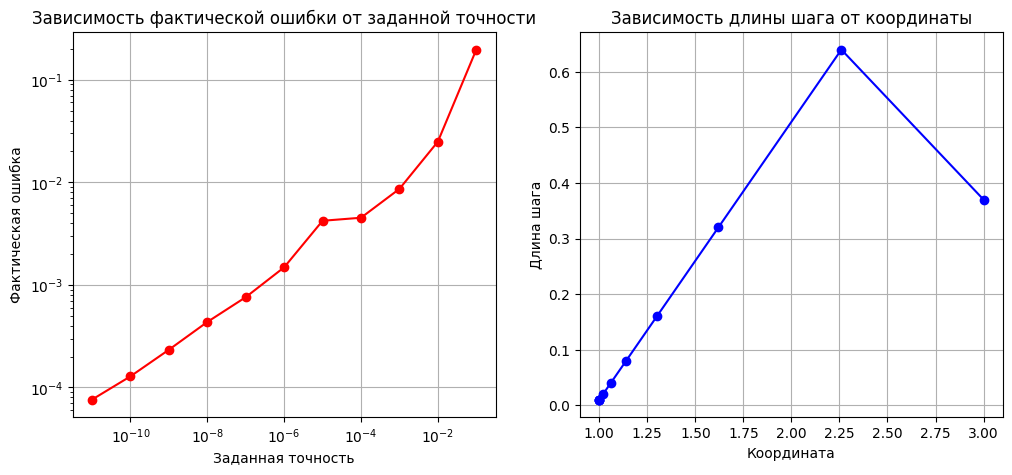

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].loglog(eps_list, errors_from_eps, color='red', marker="o")
ax[0].set_title('Зависимость фактической ошибки от заданной точности')
ax[0].set_ylabel('Фактическая ошибка')
ax[0].set_xlabel('Заданная точность')

ax[1].plot(x_list, h_list, color='blue', marker='o')
ax[1].set_title('Зависимость длины шага от координаты')
ax[1].set_ylabel('Длина шага')
ax[1].set_xlabel('Координата')

for i in range(2):
    ax[i].grid(True)

In [ ]:
# Строим зависимость фактической ошибки от фиксированной длины шага
h_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
#h_list = [i for i in np.linspace(1e-1, 1e-5, 15)]
errors_from_fix_h = []
for i in h_list:
    x, y = adams_bashforth(ODE, a, b, y0, i, step='fixed')
    error = np.linalg.norm(np.abs(y - exact_solution(x))) 
    errors_from_fix_h.append(error)
h_list

[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]

Text(0, 0.5, 'Фактическая ошибка')

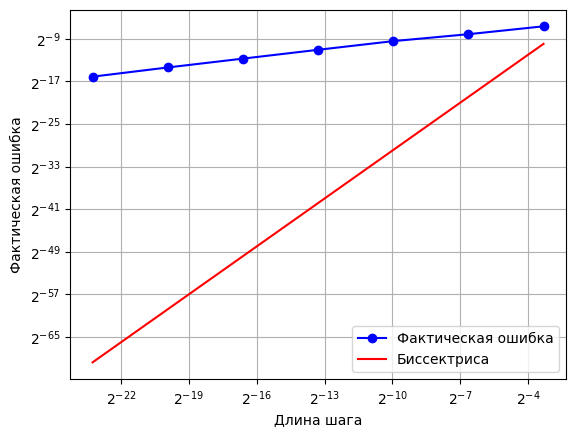

In [ ]:
plt.loglog(h_list, errors_from_fix_h, base=2, color='blue', marker='o', label='Фактическая ошибка')
plt.loglog(h_list, np.pow(h_list, 3), base=2, color='red', label='Биссектриса')
plt.grid(True)
#plt.title('Зависимость фактической ошибки от фиксированной длины шага')
plt.legend()
plt.xlabel('Длина шага')
plt.ylabel('Фактическая ошибка')

In [ ]:
# Определяем порядок метода
log_h = np.log2(h_list)
log_error = np.log2(errors_from_fix_h)
slope, _, _, _, _ = linregress(log_h, log_error)
slope

np.float64(0.4745078099511534)

In [ ]:
noise_levels = [1, 2, 3, 4, 5]
num_experiments = 20
h = 1e-1

In [ ]:
def relative_error(true_values, num_values):
    return np.linalg.norm(true_values - num_values) / np.linalg.norm(true_values)

def create_noise(data, max_noise_persent):
    noise = np.random.uniform(-max_noise_persent/100, max_noise_persent/100)
    return data * (1 + noise)

In [ ]:
results = {level: [] for level in noise_levels}

for level in noise_levels:
    for _ in range(num_experiments):
        noisy_values = create_noise(y0, level)
        num_x, num_y = adams_bashforth(ODE, a, b, noisy_values, h, eps = 1e-1)
        true_values = exact_solution(num_x)
        error = 100 * relative_error(true_values, num_y)
        results[level].append(error)

Text(0, 0.5, 'Ошибка (%)')

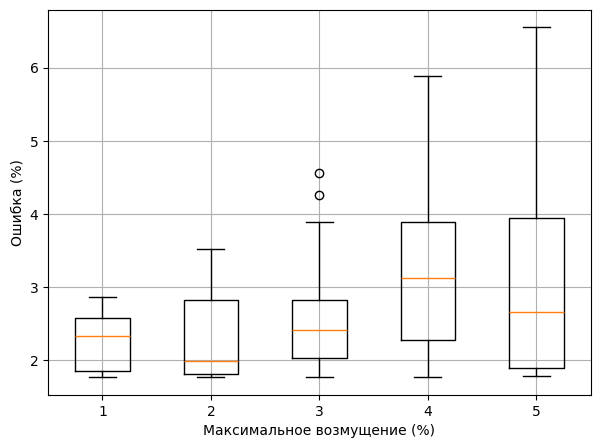

In [ ]:
plt.figure(figsize=(7, 5))

plt.boxplot([results[level] for level in noise_levels])
plt.grid('True')
plt.xlabel('Максимальное возмущение (%)')
plt.ylabel('Ошибка (%)')
#plt.title('Зависимость относительной ошибки решения ОДУ от возмущения начального условия')